# CSC413 Lab 7: Text Classification using RNNs

**Sentiment Analysis** is the problem of identifying the writer's sentiment given a piece of text.
Sentiment Analysis can be applied to movie reviews, feedback of other forms, emails, tweets,
course evaluations, and much more.

In this lab, we will build an RNN to classify positive vs negative tweets
We use the Sentiment140 data set, which contains tweets with either a positive
or negative emoticon. Our goal is to determine whether which type of
emoticon the tweet (with the emoticon removed) contained. The dataset was actually collected by
a group of students, much like you, who are doing their first machine learning projects.

By the end of this lab, you will be able to:

- Use PyTorch to train an RNN model
- Apply and analyze the components of an RNN model
- Explain how batching is done on sequence data, where the training data in a batch may have different lengths
- Use pre-trained word embeddings as part of a transfer learning strategy for text classification
- Understand the bias that exists in word embeddings and language models.

Acknowledgements:

- Data is sampled from http://help.sentiment140.com/for-students


Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus. If you are working alone,
click "Working Alone".

Submit the ipynb file `lab10.ipynb` on Markus
**containing all your solutions to the Graded Task**s.
Your notebook file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your output showing several positive tweets. (1 point)
- Part 2. Your implementation of the RNN. (5 point)
- Part 2. Your explanation of the shapes of `wordemb`. (1 point)
- Part 2. Your explanation of the shapes of `h` and `out`. (2 points)
- Part 3. Your demonstration of the model's ability to "overfit" on a data set. (1 point)
- Part 3. Your output from training the model on the full data set. (1 point)
- Part 3. Your comparison of using a different architecture from before. (2 points)
- Part 4. Your implementation of `MyGloveRnn`. (2 points)
- Part 4. Your explanation of why `MyGloveRNN` requires fewer iteration to obtain "good" accuracy. (1 point)
- Part 4. Your comparison of `MyGloveRNN` and `MyRNN` in low data settings. (1 point)
- Part 4. Your explanation of where the biases in embeddings come from, and whether our model will have the same sorts of biases. (1 point)
- Part 5. Your reflection on the sentiment analysis task. (2 points)


## Part 1. Data

Start by running these two lines of code to download the data on to Google Colab.

In [ ]:
# Download tutorial data files.
!wget https://www.cs.toronto.edu/~lczhang/413/sample_tweets.csv

--2024-03-29 15:01:42--  https://www.cs.toronto.edu/~lczhang/413/sample_tweets.csv
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11099815 (11M) [text/csv]
Saving to: ‘sample_tweets.csv’

sample_tweets.csv   100%[===================>]  10.58M  35.8MB/s    in 0.3s    

2024-03-29 15:01:43 (35.8 MB/s) - ‘sample_tweets.csv’ saved [11099815/11099815]



As always, we start by understanding what our data looks like. Notice that the
test set has been set aside for us. Both the training and test set files follow
the same format. Each line in the csv file contains the tweet text,
the string label "4" (positive) or "0" (negative), and some additional information about the tweet.

In [ ]:
import csv
datafile = "sample_tweets.csv"

# Training/Validation set
data = csv.reader(open(datafile))
for i, line in enumerate(data):
    print(line)
    if i > 10:
        break

['0', '1467810672', 'Mon Apr 06 22:19:49 PDT 2009', 'NO_QUERY', 'scotthamilton', "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"]
['0', '1467812025', 'Mon Apr 06 22:20:09 PDT 2009', 'NO_QUERY', 'mimismo', '@twittera que me muera ? ']
['0', '1467812723', 'Mon Apr 06 22:20:19 PDT 2009', 'NO_QUERY', 'TLeC', "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . ."]
['0', '1467813782', 'Mon Apr 06 22:20:34 PDT 2009', 'NO_QUERY', 'gi_gi_bee', '@FakerPattyPattz Oh dear. Were you drinking out of the forgotten table drinks? ']
['0', '1467818481', 'Mon Apr 06 22:21:46 PDT 2009', 'NO_QUERY', 'lionslamb', "He's the reason for the teardrops on my guitar the only one who has enough of me to break my heart "]
['0', '1467824967', 'Mon Apr 06 22:23:28 PDT 2009', 'NO_QUERY', 'playboybacon', "Mo jobs, no money.  how in the hell is min wage here 4 f'n clams an hour?"]
['0', '1467835305', 'Mon Apr 06 2

**Task**: How many positive and negative tweets are in this file?

In [ ]:
# TODO
from collections import Counter
print(Counter(x[0] for x in csv.reader(open(datafile))))

Counter({'4': 40197, '0': 39694})


**Graded Task**: We have printed several negative tweets above.
Print 10 positive tweets.

In [ ]:
# TODO: Please make sure to include both your code and the
# printed output
positive_counter = 0
for i, line in enumerate(data):
  if line[0] == "4":
    print(line)
    positive_counter += 1
    if positive_counter == 10:
      break

['4', '1467822272', 'Mon Apr 06 22:22:45 PDT 2009', 'NO_QUERY', 'ersle', 'I LOVE @Health4UandPets u guys r the best!! ']
['4', '1467822814', 'Mon Apr 06 22:22:54 PDT 2009', 'NO_QUERY', 'misstoriblack', 'Just added tweetie to my new iPhone ']
['4', '1467822936', 'Mon Apr 06 22:22:57 PDT 2009', 'NO_QUERY', 'adamjackson', "Catching Up on Emails, RSS and Random BACN. Then I'm cutting out early tonight (11:30PM) to have Dinner with @lauraw "]
['4', '1467823405', 'Mon Apr 06 22:23:03 PDT 2009', 'NO_QUERY', 'gattermeier', 'reaching amritsar in an hour and (if i find a bus) should be at wagah border by 2pm  - http://bkite.com/06fuJ']
['4', '1467823919', 'Mon Apr 06 22:23:10 PDT 2009', 'NO_QUERY', 'loveshine', 'YAY! found a new cuddle buddy ']
['4', '1467841923', 'Mon Apr 06 22:27:57 PDT 2009', 'NO_QUERY', 'AishaNH', "@JonathanRKnight hmm you have a lot to say tonight! That's great!  Of course, here I am up late reading it. haha"]
['4', '1467842136', 'Mon Apr 06 22:28:01 PDT 2009', 'NO_QUERY', 

We will now split the dataset into training, validation, and test sets:

In [ ]:
# read the data; convert labels into integers
data = [(review, int(label=='4'))  # label 1 = positive, 0 = negative
        for label, _, _, _, _, review in csv.reader(open(datafile))]

# shuffle the data, since the file stores all negative tweets first
import random
random.seed(42)
random.shuffle(data)

train_data = data[:50000]
val_data = data[50000:60000]
test_data = data[60000:]

In order to be able to use neural networks to make predictions about these tweets,
we need to begin by convert these tweets into sequences of numbers, each representing
a words. This is akin to a one-hot encoding: each word will be converted into an
a number representing the unique *index* of that word.

Although we could do this conversion by writing our own python code,
torch has a package called **torchtext** that has utilities useful for text classification
and generation tasks.
In particular, the `Vocab` class and `build_vocab_from_iterator` will be useful for us
for building the mapping from words to indices.

In [ ]:
import torchtext

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab, build_vocab_from_iterator

# we will *tokenize* each word by using a tokenzier from
# https://pytorch.org/text/stable/data_utils.html#get-tokenizer

tokenizer = get_tokenizer("basic_english")
train_data_words = [tokenizer(x) for x, t in train_data]

# build the vocabulary object. the parameters to this function
# is described below
vocab = build_vocab_from_iterator(train_data_words,
                                  specials=['<bos>', '<eos>', '<unk>', '<pad>'],
                                  min_freq=10)

# set the index of a word not in the vocabulary
vocab.set_default_index(2) # this is the index of the `<unk>` keyword

Now, `vocab` is an object of class `Vocab` (see more here [https://pytorch.org/text/stable/vocab.html](https://pytorch.org/text/stable/vocab.html) )
that provides functionalities for converting words into their indices.
In addition to words appearing in the training set, ther are four special tokens that
we use, akin to placeholder words:

- `<bos>`, to indicate the beginning of a sequence.
- `<eos>`, to indicate the end of a sequence.
- `<unk>`, to indicate a word that is *not* in the vocabulary. This includes
  words that appear too infrequently to be included in the vocabulary, and any
  other words in the validation/test sets that are not see in training.
- `<pad>`, used for padding shorter sequences in a batch: since each tweet
  may have different length, the shorter tweets in each batch will be padded with
  the `<pad>` token so that each sequence (tweet) in a batch has the same length.

The `min_freq` parameter identifies the minimum number of times a word must appear in the
training set in order to be included in the vocabulary.

Here you can see the `vocab` object in action:

In [ ]:
# Print the number of words in the vocabulary
print(len(vocab))

# Convert a tweet into a sequence of word indices.
tweet = 'The movie Pneumonoultramicroscopicsilicovolcanoconiosis is a good movie, it is very funny'
tokens = tokenizer(f'<bos> {tweet} <eos>')
print(tokens)
indices = vocab.forward(tokens)
print(indices)

4117
['<bos>', 'the', 'movie', 'pneumonoultramicroscopicsilicovolcanoconiosis', 'is', 'a', 'good', 'movie', ',', 'it', 'is', 'very', 'funny', '<eos>']
[0, 9, 257, 2, 17, 11, 39, 257, 10, 15, 17, 137, 363, 1]


**Task**: What is the index of the `<pad>` token?

In [ ]:
# TODO: write code to identify the index of the `<pad>` token
tokens = tokenizer(f'<pad>')
print(tokens)
indices = vocab.forward(tokens)
print(indices)

['<pad>']
[3]


Now let's apply this transformation to the entire set of training, validation, and test data.

In [ ]:

def convert_indices(data, vocab):
    """Convert data of form [(tweet, label)...] where tweet is a string
    into an equivalent list, but where the tweets represented as a list
    of word indices.
    """
    return [(vocab.forward(tokenizer(f'<bos> {text} <eos>')), label)
            for (text, label) in data]

train_data_indices = convert_indices(train_data, vocab)
val_data_indices = convert_indices(val_data, vocab)
test_data_indices = convert_indices(test_data, vocab)

We have seen that PyTorch's `DataLoader` provides an easy way to form minibatches
when we worked with image data. However, text and sequence data is more challenging to
work with since the sequences may not be the same length.

Although we can (and will!) continue to use `DataLoader` for our text data, we need to
provide a function that merges sequences of various lengths into two PyTorch tensors
correspondingg to the inputs and targets for that batch.


**Task**: Following the instructions below, complete the `collate_batch` function,
which creates the input and target tensors
for a batch of data.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    """
    Returns the input and target tensors for a batch of data

    Parameters:
        `batch` - An iterable data structure of tuples (indices, label),
                  where `indices` is a sequence of word indices, and
                  `label` is either 1 or 0.

    Returns: a tuple `(X, t)`, where
        - `X` is a PyTorch tensor of shape (batch_size, sequence_length)
        - `t` is a PyTorch tensor of shape (batch_size)
    where `sequence_length` is the length of the longest sequence in the batch
    """

    text_list = []  # collect each sample's sequence of word indices
    label_list = [] # collect each sample's target labels
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        # TODO: what do we need to do with `label`?
        label_list.append(label)

    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.tensor(label_list) # TODO
    return X, t


train_dataloader = DataLoader(train_data_indices, batch_size=10, shuffle=True,
                              collate_fn=collate_batch)

With the above code in mind, we should be able to extract batches from `train_dataloader`.
Notice that `X.shape` is different in each batch.
You should also see that the index `3` is used to pad shorter sequences in in a batch.

In [ ]:
for i, (X, t) in enumerate(train_dataloader):
    print(X.shape, t.shape)
    if i >= 10:
        break

print(X)

torch.Size([10, 35]) torch.Size([10])
torch.Size([10, 34]) torch.Size([10])
torch.Size([10, 33]) torch.Size([10])
torch.Size([10, 30]) torch.Size([10])
torch.Size([10, 30]) torch.Size([10])
torch.Size([10, 37]) torch.Size([10])
torch.Size([10, 33]) torch.Size([10])
torch.Size([10, 30]) torch.Size([10])
torch.Size([10, 31]) torch.Size([10])
torch.Size([10, 30]) torch.Size([10])
torch.Size([10, 28]) torch.Size([10])
tensor([[   0,   89, 2932,   10,   15,  274,   47,   15,    7,   20,  142,   18,
           13,    4,  154,  353,  172,   63,    1,    3,    3,    3,    3,    3,
            3,    3,    3,    3],
        [   0,    2,   95,    2,   16,    6,    2,    2,    1,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,    3],
        [   0,    2,    2, 1145,   23,    2,   16,    1,    3,    3,    3,    3,
            3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
            3,    3,    3,  

**Task**: Why does each sequence begin with the token `0`, and end with the token `1` (ignoring
the paddings).

In [ ]:
# TODO: Your explanation goes here
# because we notice that in the previous part, the index of token <bos> is 0,
# and the index of <eos> is 1. The actual tweet is wrapped in these 2 tokens.
# That's why each sequence begins with token 0 and ends with token 1.

## Part 2. Model

We will use a recurrent neural network model to classify positive vs negative
sentiments. Our RNN model will have three components that are typical in a
sequence classification model:

- An *embedding layer*, which will map each word index (akin to a one-hot embedding)
  into a low-dimensional vector. This layer as having the same functionality as the
  weights $W^{(word)}$ from lab 2.
- A *recurrent layer*, which performs the recurrent neural network computation.
  The input to this layer is the low-dimensional embedding vectors
  for each word in the sequence.
- A *fully connected layer*, which computes the final binary classification using
  features computed from the recurrent layer. Think about how you can combine the per-timestep
  output of the RNN into one final prediction.

Let's define the model that we will use, and then explore it step by step.

**Graded Task**: Implement the forward pass of the model and the RNN component.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MyRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes):
        super(MyRNN, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.emb = nn.Embedding(vocab_size, emb_size)
        # TODO: Your code here
        self.rnn = nn.RNN(self.emb_size, self.hidden_size, batch_first=True,
                          nonlinearity='relu', num_layers=2, bidirectional=True)
        self.fc = nn.Linear(2 * self.hidden_size, num_classes)
        self.layer_norm = nn.LayerNorm(2 * hidden_size)

    def forward(self, X):
        # TODO: Your code here
        x_emb = self.emb(X)
        rnn_out, hn = self.rnn(x_emb)
        hidden = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        norm_out = self.layer_norm(hidden)  # Layer normalization
        out = self.fc(norm_out)

        return out

model = MyRNN(len(vocab), 128, 64, 2)

To explore exactly what this model is doing, let's grab one batch of data from
the data loader we created. We will observe, step-by-step, what computation will be
performed on the input `X` to obtain the final prediction. We do this by
emulating the `forward` method of the `MyRNN` function.

In [ ]:
X, t = next(iter(train_dataloader))

print(X.shape)

torch.Size([10, 26])


**Graded Task**: Run the code below to check the shape of `wordemb`.
What shape does this tensor have?  Explain what each dimension in this shape means.

In [ ]:
wordemb = model.emb(X)

print(wordemb.shape)

# TODO: Include your explanation here
# the shape of this tensor is [10, 26, 128]
# it means the batch size is 10,
# sequence length is 26,
# and embedding size is 128.

torch.Size([10, 26, 128])


**Graded Task**: Run the code below, which computes the RNN forward pass,
with `wordemb` as input.
What shape do the tensors `h` and `out` have?  Explain what these tensors correspond to.
(See the RNN reference [https://pytorch.org/docs/stable/generated/torch.nn.RNN.html](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) on the PyTorch documentation page.)

In [ ]:
# If you get a problem here, rename your recurrent unit ;)
h, out = model.rnn(wordemb)

print(h.shape)
print(out.shape)

# The tensors `h` and `out` are related. To see the relation,
# choose an index in the batch and compare the following two
# vectors in `h` and `out`.
index = 2 # choose an index to iterate through the batch
print(h[index, -1, :])
print(out[0, index, :])

# TODO: Include your explanation here
# the shape of h is [10, 26, 64]
# the shape of out is [1, 10, 64]
# h has batch size = 10, sequence length = 26, and hidden size = 64.
# out has number of layer = 1 and one direction. Its batch size = 10
# and hidden size = 64.

torch.Size([10, 26, 128])
torch.Size([4, 10, 64])
tensor([1.0406, 0.0935, 0.1010, 0.0461, 0.4603, 0.0000, 0.0000, 0.1110, 0.0431,
        0.2318, 0.3330, 0.2944, 0.8092, 0.0228, 0.0000, 0.0000, 0.5545, 0.3158,
        0.0000, 0.0000, 0.4354, 0.0000, 0.2511, 0.0000, 0.3602, 0.3232, 0.7754,
        0.3076, 0.0000, 0.0000, 0.1502, 1.1610, 0.1299, 0.3394, 0.3371, 1.2374,
        0.0000, 0.0000, 0.0000, 0.4668, 0.0000, 0.4206, 0.0000, 0.0000, 0.9725,
        0.0000, 0.2679, 0.0000, 0.2025, 0.0000, 0.2553, 0.0000, 0.0732, 0.0000,
        0.9624, 0.0000, 0.0000, 0.7798, 1.7403, 0.0000, 0.0000, 0.7911, 0.4226,
        0.0000, 0.0000, 0.4674, 0.0000, 0.0000, 0.6332, 0.0537, 0.0000, 0.4029,
        0.0000, 0.0000, 0.5842, 0.4406, 0.0122, 0.0000, 0.0000, 0.0819, 0.3150,
        0.0000, 0.0000, 0.0000, 0.0044, 0.0000, 0.0000, 0.8332, 0.1446, 0.0613,
        0.8679, 0.0974, 0.0000, 0.0000, 0.1110, 0.0000, 0.0000, 0.0000, 0.3235,
        0.0000, 0.5039, 0.4356, 0.2513, 0.0000, 0.0000, 0.0000, 0.4466

There is one more thing we need to do before training the model, which is
to write a function to estimate the accuracy of the model. This is done for
you below.

In [ ]:
# if you get a problem here, check how you implemented the output of your model
def accuracy(model, dataset, max=1000):
    """
    Estimate the accuracy of `model` over the `dataset`.
    We will take the **most probable class**
    as the class predicted by the model.

    Parameters:
        `model`   - An object of class nn.Module
        `dataset` - A dataset of the same type as `train_data`.
        `max`     - The max number of samples to use to estimate
                    model accuracy

    Returns: a floating-point value between 0 and 1.
    """

    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,  # use batch size 1 to prevent padding
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
        if i >= max:
            break
    return correct / total

accuracy(model, train_data_indices) # should be close to half

0.4905094905094905

## Part 3. Training

In this section, we will train the `MyRNN` model to classify tweets.
As the models that we are building begin to increase in complexity, it is important
to use good debugging techniques. In this section, we will introduce the technique of
checking whether the model and training code is able to overfit on a small training set.
This is a way to check for bugs in the implementation.

**Task**: Complete the training code below

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train_model(model,                # an instance of MLPModel
                train_data,           # training data
                val_data,             # validation data
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,        # how often (in # iterations) to track metrics
                plot=True):           # whether to plot the training curve
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True) # reshuffle minibatches every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # these lists will be used to track the training progress
    # and to plot the training curve
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts) # TODO

                loss = criterion(z, labels) # TODO

                loss.backward() # propagate the gradients
                optimizer.step() # update the parameters
                optimizer.zero_grad() # clean up accumualted gradients

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

**Graded Task**: As a way to check the model and training code,
check if your model can obtain a 100\% training accuracy relatively quickly
(e.g. within less than a minute of training time), when training on only the
first 20 element of the training data.

In [ ]:
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
# TODO: Include your code and output
train_model(model, train_data_indices[:20], val_data_indices[:20] , batch_size=10,
            num_epochs=50, plot_every=10, plot=False)

10 Loss: 0.4830723702907562 Train Acc: 0.65 Val Acc: 0.3
20 Loss: 0.27280527353286743 Train Acc: 0.95 Val Acc: 0.4
30 Loss: 0.02235175110399723 Train Acc: 1.0 Val Acc: 0.35
40 Loss: 0.008333005011081696 Train Acc: 1.0 Val Acc: 0.3
50 Loss: 0.004969590809196234 Train Acc: 1.0 Val Acc: 0.45
60 Loss: 0.004522236995398998 Train Acc: 1.0 Val Acc: 0.5
70 Loss: 0.003174875397235155 Train Acc: 1.0 Val Acc: 0.5
80 Loss: 0.0028540263883769512 Train Acc: 1.0 Val Acc: 0.5
90 Loss: 0.002752964850515127 Train Acc: 1.0 Val Acc: 0.5
100 Loss: 0.0023470863234251738 Train Acc: 1.0 Val Acc: 0.5


**Task**: Will this model that you trained above have a high accuracy over
the validation set? Explain why or why not.

In [ ]:
# TODO: Your explanation goes here
# the validation accuracy would be considerably lower, since the training set is too small
# and can not represent the general feature of the actual data.


**Graded Task**: Train your model on the full data set. What validation accuracy
can you achieve? (Our implementation achieved just shy of 80% without much tuning of HPs, can you match this?)

50 Loss: 0.6770226955413818 Train Acc: 0.5554445554445554 Val Acc: 0.5444555444555444
100 Loss: 0.6794403195381165 Train Acc: 0.6233766233766234 Val Acc: 0.5914085914085914
150 Loss: 0.6277244091033936 Train Acc: 0.6583416583416584 Val Acc: 0.6133866133866134
200 Loss: 0.5922433137893677 Train Acc: 0.7212787212787213 Val Acc: 0.6673326673326674
250 Loss: 0.6392089128494263 Train Acc: 0.7202797202797203 Val Acc: 0.6653346653346653
300 Loss: 0.5940706729888916 Train Acc: 0.7052947052947053 Val Acc: 0.6703296703296703
350 Loss: 0.5804022550582886 Train Acc: 0.7362637362637363 Val Acc: 0.7032967032967034
400 Loss: 0.5411274433135986 Train Acc: 0.7672327672327672 Val Acc: 0.7392607392607392
450 Loss: 0.4967482089996338 Train Acc: 0.7732267732267732 Val Acc: 0.7352647352647352
500 Loss: 0.5473392009735107 Train Acc: 0.7672327672327672 Val Acc: 0.7442557442557443
550 Loss: 0.541826605796814 Train Acc: 0.7322677322677322 Val Acc: 0.7122877122877123
600 Loss: 0.45210760831832886 Train Acc: 0.76

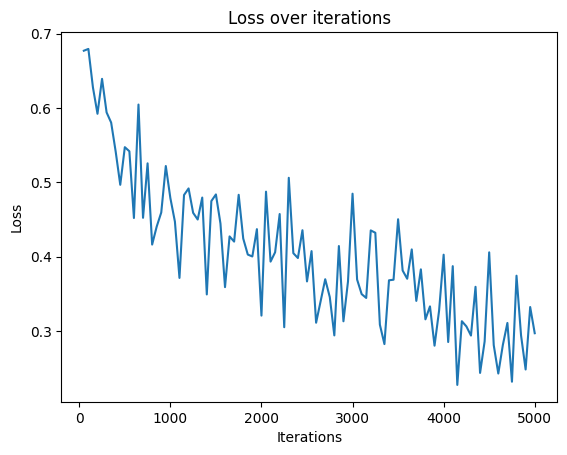

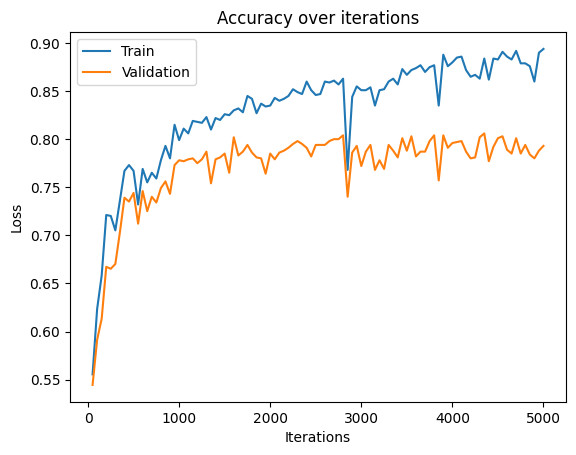

In [ ]:
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
# TODO: Include your code and output
train_model(model, train_data_indices, val_data_indices, plot=True)

**Graded task:** There are several different variants of RNN architectures. Chose a *different one* from the one you used previously and reimplement the model and the training loop below. It is OK to copy/paste the majority of the code. Make sure you have train and eval loss as before. Compare the final validation accuracy and comment on whether you obtained the expected results. Why/why not?

In [ ]:
# TODO: Your code here
# choosing LSTM
import torch.nn as nn

class MyLSTMRNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, num_classes):
        super(MyLSTMRNN, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes

        self.emb = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, X):
        x_emb = self.emb(X)
        lstm_out, (hidden, _) = self.lstm(x_emb)

        hn = hidden[-1,:,:]

        out = self.fc(hn)
        return out

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def train_LSTM_model(model, train_data, val_data, learning_rate=0.001, batch_size=100, num_epochs=10, plot_every=100, plot=True):
    train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_batch)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0
    try:
        for epoch in range(num_epochs):
          for texts, labels in train_loader:
              optimizer.zero_grad()
              outputs = model(texts)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              iter_count += 1
              if iter_count % plot_every == 0:
                  iters.append(iter_count)
                  ta = accuracy(model, train_data)
                  va = accuracy(model, val_data)
                  train_loss.append(float(loss))
                  train_acc.append(ta)
                  val_acc.append(va)
                  print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        # This try/finally block is to display the training curve
        # even if training is interrupted
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend(["Train", "Validation"])

100 Loss: 0.6833204030990601 Train Acc: 0.4995004995004995 Val Acc: 0.5194805194805194
200 Loss: 0.6894438862800598 Train Acc: 0.5464535464535465 Val Acc: 0.5534465534465535
300 Loss: 0.536547839641571 Train Acc: 0.6793206793206793 Val Acc: 0.6743256743256744
400 Loss: 0.6026241779327393 Train Acc: 0.7312687312687313 Val Acc: 0.7282717282717283
500 Loss: 0.4962598383426666 Train Acc: 0.7902097902097902 Val Acc: 0.7542457542457542
600 Loss: 0.5195988416671753 Train Acc: 0.7922077922077922 Val Acc: 0.7452547452547452
700 Loss: 0.6188079714775085 Train Acc: 0.8021978021978022 Val Acc: 0.7532467532467533
800 Loss: 0.4811391532421112 Train Acc: 0.7952047952047953 Val Acc: 0.7732267732267732
900 Loss: 0.4388411045074463 Train Acc: 0.8181818181818182 Val Acc: 0.7752247752247752
1000 Loss: 0.4680716395378113 Train Acc: 0.8141858141858141 Val Acc: 0.7762237762237763
1100 Loss: 0.5616243481636047 Train Acc: 0.8241758241758241 Val Acc: 0.7632367632367633
1200 Loss: 0.3986513912677765 Train Acc: 0

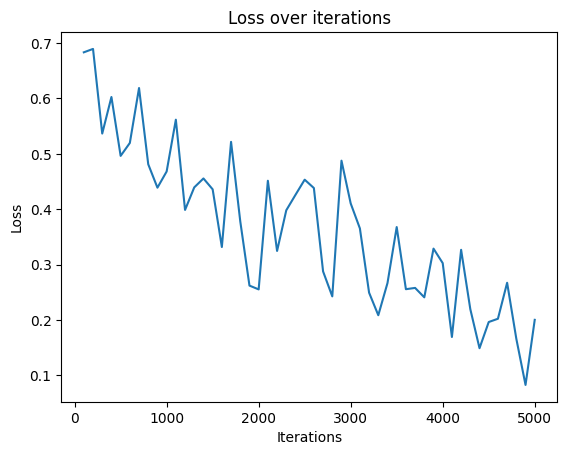

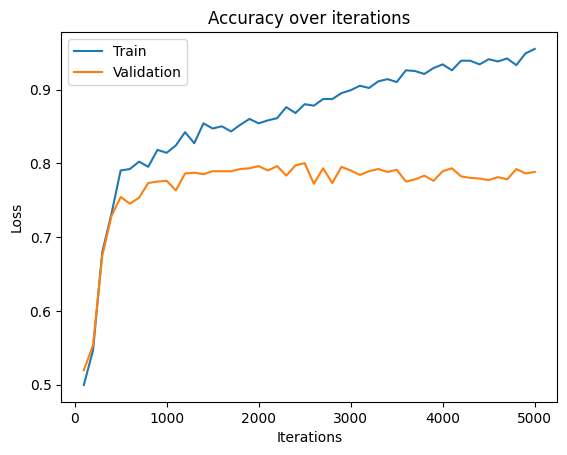

In [ ]:
vocab_size = len(vocab)
emb_size = 128
hidden_size = 64
num_classes = 2

model = MyLSTMRNN(vocab_size, emb_size, hidden_size, num_classes)
train_LSTM_model(model, train_data_indices, val_data_indices)

We could see that both the training and validation accuracy of LSTM is higher.

## Part 4. Pretrained Embeddings

As we saw in the previous lab on images, **transfer learning** is a useful technique
in practical machine learning, especially in low-data settings:
instead of training an entire neural network from scratch, we use (part of) a
model that is pretrained on large amounts of similar data. We use the intermediate
state of this pretrained model as features to our model---i.e. we use the pretrained
models to compute *features*.

Just like with images, using a pretrained model is an important strategy for working
with text. Large language models is an excellent demonstration of how generalizable
pretrained features can be.

In this part of the lab, we will use a slightly older idea of using pretrained *word embeddings*.
In particular, instead of training our own `nn.Embedding` layer, we will use
GloVe embeddings (2014) [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)
trained on a large data set containing all of Wikipedia and other webpages.

Nowadays, large language model (LLMs), including those with APIs provided by various organizations,
can also be used to map words/sentences into embeddings.
However, the basic idea of using pretrained models in low-data settings remains similar.
We will also identify some bias issues with pretrained word embeddings.
There is evidence that these types of bias issues
continues to persist in LLMs as well.

In [ ]:
from torchtext.vocab import GloVe

glove = torchtext.vocab.GloVe(name="6B", dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:59<00:00, 6696.65it/s]


**Task**: Run the below code to print the GloVe word embedding for the word "cat".

In [ ]:
print(glove['cat'])

tensor([-0.2935,  0.3325, -0.0474, -0.1225,  0.0720, -0.2341, -0.0624, -0.0037,
        -0.3946, -0.6941,  0.3673, -0.1214, -0.0445, -0.1527,  0.3486,  0.2293,
         0.5436,  0.2521,  0.0980, -0.0873,  0.8706, -0.1221, -0.0798,  0.2871,
        -0.6856, -0.2727,  0.2206, -0.7575,  0.5629,  0.0914, -0.7100, -0.3142,
        -0.5683, -0.2668, -0.6010,  0.2696, -0.1799,  0.1070, -0.5786,  0.3816,
        -0.6713,  0.1093,  0.0794,  0.0224, -0.0811,  0.0112,  0.6709, -0.1909,
        -0.3368, -0.4847, -0.3541, -0.1521,  0.4450,  0.4638,  0.3841,  0.0451,
        -0.5908,  0.2176,  0.3858, -0.4457,  0.0093,  0.4420,  0.0971,  0.3801,
        -0.1188, -0.4272, -0.3101, -0.0251,  0.1269, -0.1347,  0.1198,  0.7625,
         0.2524, -0.2693,  0.0686, -0.1007,  0.0111, -0.1853,  0.4498, -0.5751,
         0.1228, -0.0649,  0.0445, -0.0210, -0.0698, -0.4733, -0.4307,  0.3916,
        -0.0478, -0.9366, -0.5513, -0.1422, -0.1583,  0.1562,  0.0705,  0.1989,
         0.1894, -0.1934, -0.4659, -0.02

Unfortunately, it is not straightforward to add the `<pad>`, `<unk>`, `<bos>` and `<eos>`
tokens. So we will do without them.

**Task**: Run the below code to look up GloVe word indices for the training, validation, and
test sets.

In [ ]:
def convert_indices_glove(data, default=len(glove)-1):
    result = []
    for text, label in data:
        words = tokenizer(text) # for simplicity, we wont use <bos> and <eos>
        indices = []
        for w in words:
            if w in glove.stoi:
                indices.append(glove.stoi[w])
            else:
                # this is a bit of a hack, but we will repurpose *last* word
                # (least common word) appearing in the GloVe vocabluary as our
                # '<pad>' token
                indices.append(default)
        result.append((indices, label),)
    return result

train_data_glove = convert_indices_glove(train_data)
val_data_glove = convert_indices_glove(val_data)
test_data_glove = convert_indices_glove(test_data)

**Graded task**: Now, we will modify the `MyRNN` to use the pretrained GloVe vectors. Make sure to not update the glove embeddings. You can reuse code from above.

In [ ]:
class MyGloveRNN(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(MyGloveRNN, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        # TODO: Your code here
        self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=True)
        self.rnn = nn.RNN(self.emb_size, self.hidden_size, batch_first=True,
                          nonlinearity='relu', num_layers=2, bidirectional=True)
        self.fc = nn.Linear(2 * self.hidden_size, num_classes)
        self.layer_norm = nn.LayerNorm(2 * hidden_size)

    def forward(self, X):
        # TODO: Your code here
        x_emb = self.emb(X)
        rnn_out, hn = self.rnn(x_emb)
        hidden = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        norm_out = self.layer_norm(hidden)  # Layer normalization
        out = self.fc(norm_out)
        return out

    def parameters(self):
        # do not return the parameters of self.emb
        # TODO: Your code here
        for name, param in self.named_parameters():
            if name != 'emb.weight':
                yield param

model = MyGloveRNN(64, 2)

**Task** Train this model. Use comparable hyperparameters so that you can compare
your result against `MyRNN`.

In [ ]:
# TODO: Train your model here, and include the output
train_model(model, train_data_glove, val_data_glove)

50 Loss: 0.6633110642433167 Train Acc: 0.6053946053946054 Val Acc: 0.5764235764235764
100 Loss: 0.646317720413208 Train Acc: 0.6123876123876124 Val Acc: 0.6253746253746254
150 Loss: 0.6213607788085938 Train Acc: 0.6683316683316683 Val Acc: 0.6763236763236763
200 Loss: 0.5789912939071655 Train Acc: 0.7172827172827173 Val Acc: 0.7132867132867133
250 Loss: 0.6955294013023376 Train Acc: 0.7292707292707292 Val Acc: 0.7492507492507493
300 Loss: 0.6528284549713135 Train Acc: 0.6863136863136863 Val Acc: 0.6793206793206793
350 Loss: 0.6204338669776917 Train Acc: 0.7482517482517482 Val Acc: 0.7532467532467533
400 Loss: 0.5181957483291626 Train Acc: 0.7382617382617382 Val Acc: 0.7422577422577422
450 Loss: 0.4484299421310425 Train Acc: 0.7502497502497503 Val Acc: 0.7412587412587412
500 Loss: 0.577133059501648 Train Acc: 0.7582417582417582 Val Acc: 0.7542457542457542
550 Loss: 0.3348675072193146 Train Acc: 0.7672327672327672 Val Acc: 0.7772227772227772
600 Loss: 0.46435946226119995 Train Acc: 0.764

**Graded Task**: You might notice that a *very* smaller number of
iterations will be required to train this model to a reasonable
performance (e.g. >70% validation accuracy). Why might this be?

In [ ]:
# TODO: Include your explanation here
# Glove can capture the semantics of words and thus doesn't have to learn these features
# from scratch. It used a large and diverse dataset to train and thus generalizes well to different
# tasks.

**Graded Task**: Train both MyGloveRNN and MyRNN models using the corresponding
embeddings (pretrained vs. not), **but only with the first 200 data points in the
training set**. How do the validation accuracies compare between these two models?

5 Loss: 0.6927101016044617 Train Acc: 0.585 Val Acc: 0.5044955044955045
10 Loss: 0.6581019163131714 Train Acc: 0.595 Val Acc: 0.5114885114885115
15 Loss: 0.6927204728126526 Train Acc: 0.595 Val Acc: 0.5134865134865135
20 Loss: 0.5888150930404663 Train Acc: 0.585 Val Acc: 0.5114885114885115
25 Loss: 0.6350706219673157 Train Acc: 0.615 Val Acc: 0.5104895104895105
30 Loss: 0.5693411827087402 Train Acc: 0.64 Val Acc: 0.5154845154845155
35 Loss: 0.5338439345359802 Train Acc: 0.64 Val Acc: 0.5184815184815185
40 Loss: 0.4466682970523834 Train Acc: 0.695 Val Acc: 0.5214785214785215


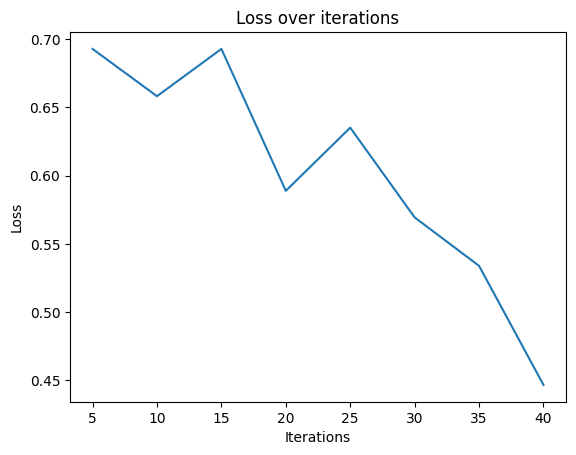

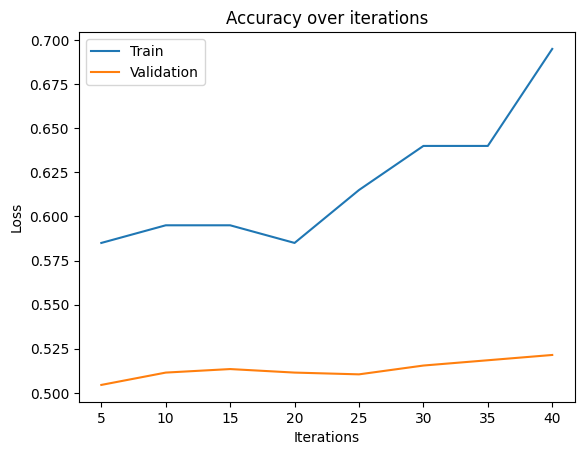

In [ ]:
# TODO: Training code for MyGloveRNN.
# Include outputs and training curves in your submission
model_glove = MyGloveRNN(
              hidden_size=64,
              num_classes=2)
train_model(model_glove, train_data_glove[:200], val_data_glove, batch_size=40,
            num_epochs=8, plot_every=5, plot=True)

5 Loss: 0.7985905408859253 Train Acc: 0.565 Val Acc: 0.5064935064935064
10 Loss: 0.6477271914482117 Train Acc: 0.565 Val Acc: 0.5064935064935064
15 Loss: 0.6144391894340515 Train Acc: 0.565 Val Acc: 0.5064935064935064
20 Loss: 0.6726334691047668 Train Acc: 0.565 Val Acc: 0.5064935064935064
25 Loss: 0.5912821888923645 Train Acc: 0.565 Val Acc: 0.5064935064935064
30 Loss: 0.6418216824531555 Train Acc: 0.565 Val Acc: 0.5064935064935064
35 Loss: 0.5522448420524597 Train Acc: 0.565 Val Acc: 0.5064935064935064
40 Loss: 0.4933927655220032 Train Acc: 0.565 Val Acc: 0.5074925074925075


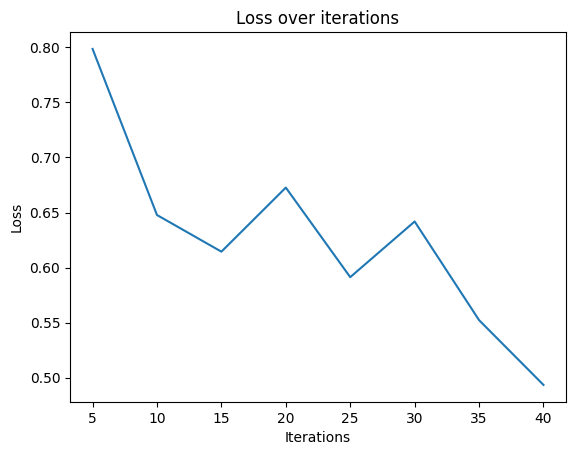

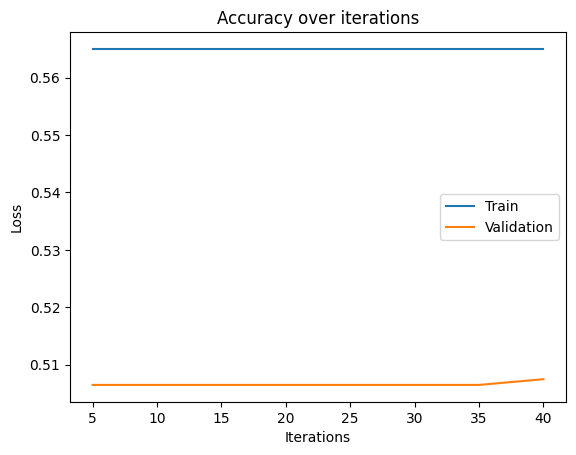

In [ ]:
# TODO: Training code for MyRNN
# Include outputs and training curves in your submission
model = MyRNN(vocab_size=len(vocab),
              emb_size=300,
              hidden_size=64,
              num_classes=2)
# TODO: Include your code and output
train_model(model, train_data_indices[:200], val_data_indices, batch_size=40,
            num_epochs=8, plot_every=5, plot=True)

In [ ]:
# TODO: Compare the validation accuaries here
# they are similar at around 0.5. The Glove model performs slightly better.

Machine learning models have an air of "fairness" about them, since models
make decisions without human intervention. However, models can and do learn
whatever bias is present in the training data.
GloVe vectors seems innocuous enough: they are just representations of
words in some embedding space. Even so, we will show that the structure
of the GloVe vectors encodes the everyday biases present in the texts
that they are trained on.

We start with an example analogy to demonstrate the power of GloVe embeddings
that allows us to complete analogies by applying arithmetic operations
to the word vectors.

$$doctor - man + woman \approx ??$$

To find the answers to the above analogy, we will compute the following vector,
and then find the word whose vector representation is *closest* to it.

In [ ]:
v = glove['doctor'] - glove['man'] + glove['woman']

**Task**: Run the code below to find the closets word. You should see the word
"nurse" fairly high up in that list.

In [ ]:
def print_closest_words(vec, n=5):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[1:n+1]: 					       # take the top n
        print(glove.itos[idx], difference)

print_closest_words(v)

physician 6.7226787
nurse 6.7791734
woman 6.8218
doctors 6.963807
dentist 7.3165383


**Task**:  To compare, use a similar method to find the answer to this analogy:
$$doctor - woman + man \approx ??$$

In other words, we go the opposite direction in the "gender" axis to check
if similarly concerning analogies exist.

In [ ]:
print_closest_words(glove['doctor'] - glove['woman'] + glove['man'])

man 6.614642
physician 6.8267035
he 7.064041
mr. 7.065585
dr. 7.127458


**Task**: Compare the following two outputs.

In [ ]:
print_closest_words(glove['programmer'] - glove['man'] + glove['woman'])

programmers 6.906153
oly-2004-fhockey 7.1117373
http://www.nwguild.org 7.271939
bb94 7.282604
homemaker 7.296883


In [ ]:
print_closest_words(glove['programmer'] - glove['woman'] + glove['man'])

programmers 6.8631363
_____________________________________________ 7.49171
timewrn 7.4950824
jahch 7.561946
jihb 7.5969725


**Task**: Compare the following two outputs.

In [ ]:
print_closest_words(glove['professor'] - glove['man'] + glove['woman'])

lecturer 6.5699987
sociology 6.942095
university 6.985767
graduate 7.2252293
researcher 7.289195


In [ ]:
print_closest_words(glove['professor'] - glove['woman'] + glove['man'])

university 7.084462
prof. 7.0947814
emeritus 7.146991
harvard 7.289809
sociology 7.330031


**Task**: Compare the following two outputs.

In [ ]:
print_closest_words(glove['engineer'] - glove['man'] + glove['woman'])

technician 6.738221
engineers 7.143567
educator 7.160228
worker 7.294498
woman 7.3743315


In [ ]:
print_closest_words(glove['engineer'] - glove['woman'] + glove['man'])

engineers 7.340744
mechanic 7.6183243
engineering 7.689247
worked 7.8743134
technician 7.9948106


**Graded Task**: Explain where the bias in these embeddings come from.
Would you expect our word embeddings (trained on tweets) to be similarly
problematic? Why or why not?

In [ ]:
# TODO: Your explanation goes here
# These biases comes from the training dataset that Glove uses, which are online texts. These texts would contain
# common human biases like gender or race, and are then learned by Glove. Our tweets may not have the same problem
# as the dataset is relatively small.

## Questioning your data's assumptions

**Graded Task:** The task we attempted in this lab is "sentiment analysis". However, the "sentiment" of a short text snippet such as a tweet can be hard to estimate. Give at least 2 reasons for why sentiment analysis can be difficult. Consider the data itself, the labelling task, and the model training. This is an open ended task, so we will grade you not on giving the most correct response, but for making a (very) short but succinct argument for problems you can think of.

In [ ]:
# TODO: Your explanation goes here
# 1. without context, it is hard to know whether a person is being honest or scarcastic.
# 2. sentiment is subjective, so the labellers may have different views on whether a tweet
# is positive or negative. Thus, there may be labeling noises in the dataset.